In [1]:
import os
repo_dir = os.environ.get("REPO_DIR")
code_dir = os.path.join(repo_dir, "code/")
data_dir = os.path.join(repo_dir, "data/")
os.chdir(code_dir)

import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg
import pickle
import sklearn 
import sys
import pandas as pd
from importlib import reload

from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
import seaborn as sns

from scipy.stats import spearmanr

import geopandas as gpd

import warnings

from mosaiks.utils.imports import *


# Key prediction functions are here
from analysis.prediction_utils import (X_matrix_to_demeaned_X, df_to_demeaned_y_vars,
make_train_pred_scatterplot as make_scatterplot, cv_solve, solver_kwargs, get_truth_preds_from_kfold_results,
                             predict_y_from_kfold_dict, generalized_demean)

# Movement in quintile analysis

Here we compare quintile assignments for the global population using ADM1 data and compare to assignments based on our newly created ADM2 and grid-level data products.

This notebook is fully replicable with only code and data in the GitHub repo.

## Set colors

In [2]:
from matplotlib.cm import get_cmap

cmap = get_cmap('plasma')
color1 = cmap(0.1)
color2 = cmap(0.55)
color3 = cmap(0.9)

## Define functions

In [3]:
def get_country_bins(df,country, pop_weight=True, true_colname="adm2_pred", alt_colname="adm1_truth", 
                     diff_threshs = False):
    """
    For a country, e.g., "ETH" asssume all population within country has ADM2 HDI consistent with our preds.
    
    Set up quintile bins based on the population and the known ADM2 values.
    
    Assign a numeric (1-5) quintile bin to each ADM2 observation using ADM2 predictions
    
    Assign a numeric (1-5) quintile bin to each ADM2 observation using only the ADM1 observation.
    """
    inc_country = df[df["shapeGroup"] == country].copy()
    
    if pop_weight:
        pops = []
        alt_pops = []
        for i, row in inc_country.iterrows():
            a = np.full(row["total_pop"], row[true_colname])
            pops.append(a)
            
            if diff_threshs:
                b = np.full(row["total_pop"],row[alt_colname])
                alt_pops.append(b)
        pops = np.hstack(pops)
        threshs = np.quantile(pops, [0.2,.4,.6,.8])
        del pops
        
        if diff_threshs:
            alt_pops = np.hstack(alt_pops)
        
            alt_threshs = np.quantile(alt_pops, [0.2,.4,.6,.8])
            
            del alt_pops
        else:
            alt_threshs = threshs
    else:
        threshs = np.quantile(inc_country[true_colname], [0.2,.4,.6,.8])
        
        if diff_threshs:
            alt_threshs = np.quantile(inc_country[alt_colname], [0.2,.4,.6,.8])
        else:
            alt_threshs = threshs
    
    inc_country["true_bin"] = np.nan
    inc_country["alt_bin"] = np.nan
    
    inc_country.loc[inc_country[true_colname] < threshs[0],"true_bin"] = 1
    inc_country.loc[inc_country[true_colname] > threshs[3],"true_bin"] = 5
    ## These are going to be bias toward the middle quartile
    inc_country.loc[((inc_country[true_colname] >= threshs[0]) & (inc_country[true_colname] < threshs[1]) ),"true_bin"] = 2
    inc_country.loc[((inc_country[true_colname] > threshs[2]) & (inc_country[true_colname] <= threshs[3]) ),"true_bin"] = 4
    inc_country.loc[((inc_country[true_colname] >= threshs[1]) & (inc_country[true_colname] <= threshs[2]) ),"true_bin"] = 3
    
    
    inc_country.loc[inc_country[alt_colname] < alt_threshs[0],"alt_bin"] = 1
    inc_country.loc[inc_country[alt_colname] > alt_threshs[3],"alt_bin"] = 5
    
    inc_country.loc[((inc_country[alt_colname] >= alt_threshs[0]) & (inc_country[alt_colname] < alt_threshs[1]) ),"alt_bin"] = 2
    inc_country.loc[((inc_country[alt_colname] > alt_threshs[2]) & (inc_country[alt_colname] <= alt_threshs[3]) ),"alt_bin"] = 4
        
    inc_country.loc[((inc_country[alt_colname] >= alt_threshs[1]) & (inc_country[alt_colname] <= alt_threshs[2]) ),"alt_bin"] = 3


    
    return inc_country
    

In [4]:
def tot_array(data, inc=5):
    arr = []
    for i in range(inc):
        start = i * inc
        end = start + inc
        tot = data.iloc[start:end].sum()
        arr.append(np.full(inc,tot))
    return np.hstack(arr)

In [5]:
def add_missing_zeros(data):

    for i in range(1,6):
        for j in range(1,6):
            try:
                data.loc[(i,j)]
            except:
                data.loc[(i,j)] = 0
    return data.reset_index().groupby(["true_bin", "alt_bin"])["total_pop"].sum()

In [6]:
def make_bar_plot(df, pop_weight=True, 
                  alt_bin_text = "ADM1 assumed quintile = ", 
                  true_bin_text = "Predicted \nquintile = ",
                 x_lab_text = " \nMunicipality-level HDI quintile (this study)",
                 legend_title = "Province-level HDI quintile (Smits & Permanyer)", 
                  savepath = None):
    if pop_weight:
        data = df.groupby(["true_bin", "alt_bin"])["total_pop"].sum()
    
    else:
        data = df.groupby(["true_bin", "alt_bin"])["total_pop"].count()
    
    data = add_missing_zeros(data)
    
    data_perc = data/tot_array(data)
    data_df = data_perc.reset_index()
    
    data_df["true_bin_lab"] = true_bin_text + data_df["true_bin"].astype(int).astype(str)
    data_df["alt_bin_lab"] = alt_bin_text + data_df["alt_bin"].astype(int).astype(str)
    
    
    fig, ax = plt.subplots(figsize=(10,10))
    labels = data_df["alt_bin_lab"].unique()

    for i, label in enumerate(labels):
        rgba = cmap((i+3)/7)
        if i == 0:
            tots = np.full(5,0)
        subset = data_df[data_df["alt_bin_lab"] == label]
        values = subset["total_pop"].to_numpy() * 100
        names = subset["true_bin_lab"]

        hatch = [None,None,None,None,None]
        hatch[i] = '/'
        bar = ax.bar(names,values, width=0.35, label = label, bottom=tots, color=rgba, hatch=hatch,
                     edgecolor='white',
                    linewidth=0)
        tots = values+tots
        val_prnt = pd.Series(values.round().astype(int).astype(str)) + "%"
        val_prnt[values < 3.5] = ""

        ax.bar_label(bar, labels = val_prnt, label_type="center", color="black", size=14.5) 

    leg = ax.legend(bbox_to_anchor=(.9, 1.12),title=legend_title, frameon=True, prop={'size':16}, 
                    title_fontsize=16,ncol=5)
    leg._legend_box.align = "top"
    leg._legend_box.sep = 10

    ax.set_xlabel(x_lab_text, size=16)
    ax.tick_params(axis='x', labelsize=14 )
    ax.tick_params(axis='y', labelsize=14 )
    
    ax.set_ylim(0,100)
    if pop_weight:
        ax.set_ylabel("Population (%)", size=16)
    else:
        ax.set_ylabel("ADM2 obs (%)", size=16)
    if savepath:
        fig.savefig(savepath, dpi=300, bbox_inches="tight")

In [7]:
data = pd.read_csv(data_dir + "preds/hdi_preds_at_adm2.csv").rename(
columns = {"predicted_adm2_HDI":"adm2_pred","adm1_HDI_Smits":"adm1_truth", 
          "est_total_pop":"total_pop"})
    
data = data.loc[data["adm2_pred"].dropna().index]

In [9]:
data

,shapeID,shapeName,shapeGroup,ADM1_shapeID,GDL_ADM1,percent_overlap_GDL_ADM1,adm1_truth,total_pop,adm2_pred
0,BRN-ADM2-3_0_0-B1,Kota Batu,BRN,BRN-ADM1-3_0_0-B3,BRNt,87.00,0.830,20463,0.839422
1,BRN-ADM2-3_0_0-B2,Kilanas,BRN,BRN-ADM1-3_0_0-B3,BRNt,100.00,0.830,33308,0.888425
2,BRN-ADM2-3_0_0-B3,Tanjong Maya,BRN,BRN-ADM1-3_0_0-B4,BRNt,100.00,0.830,2942,0.794934
3,BRN-ADM2-3_0_0-B4,Serasa,BRN,BRN-ADM1-3_0_0-B3,BRNt,96.12,0.830,8955,0.894344
4,BRN-ADM2-3_0_0-B5,Mentiri,BRN,BRN-ADM1-3_0_0-B3,BRNt,99.23,0.830,20040,0.887473
...,...,...,...,...,...,...,...,...,...
111912,ZWE-ADM2-3_0_0-B85,Kwekwe Urban,ZWE,ZWE-ADM1-3_0_0-B6,ZWEr107,100.00,0.598,139439,0.681628
111913,ZWE-ADM2-3_0_0-B86,Epworth,ZWE,ZWE-ADM1-3_0_0-B10,ZWEr109,87.72,0.674,159170,0.650765
111914,ZWE-ADM2-3_0_0-B87,Ruwa,ZWE,ZWE-ADM1-3_0_0-B9,ZWEr103,91.10,0.588,83145,0.646362
111915,ZWE-ADM2-3_0_0-B88,Bindura Urban,ZWE,ZWE-ADM1-3_0_0-B4,ZWEr102,100.00,0.542,57773,0.617709


In [10]:
unique_countries = np.unique(data["shapeGroup"])

## ADM2 v ADM1 Analysis
#### Run with varied thresholds and population weighting

In [11]:
stack_incs = []

for country in unique_countries:
    stack_incs.append(get_country_bins(data, country, diff_threshs=True))
incs_and_bin = pd.concat(stack_incs)

In [12]:
data_pop = incs_and_bin.groupby(["true_bin", "alt_bin"])["total_pop"].sum()

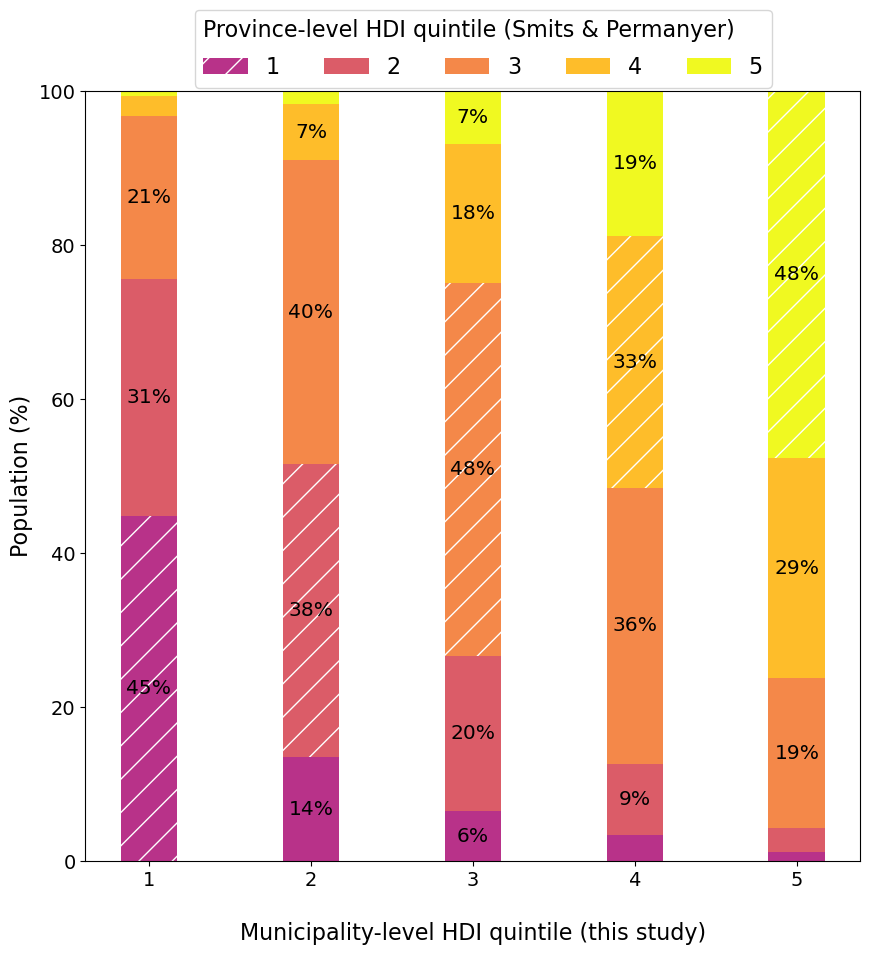

In [13]:
make_bar_plot(incs_and_bin, pop_weight=True, alt_bin_text = "", true_bin_text = "", 
              savepath=repo_dir + "figures/Figure4A.pdf",
              #savepath=None
             )

### Try version as confusion matrix

In [14]:
def make_confusion(data_pop, savepath=None, vmin=.4,vmax=52, ystr="Municipality"):
    melted = data_pop.reset_index().pivot(index='true_bin', columns='alt_bin')
    melted_d = melted.divide((melted.sum(axis=1)).to_numpy(),axis=1)
    melted_d.index = np.arange(1,6)
    melted_d.columns = np.arange(1,6)
    rounded = np.round(melted_d * 100,1)
    
    fig, ax= plt.subplots()
    sns.heatmap(rounded, annot=rounded.astype(str) + "%",
                fmt='', ax=ax,cmap="plasma", cbar_kws={"label":"Population (%)"},
               vmin=vmin,vmax=vmax)

    ax.set_xlabel("Province-level HDI quintile (Smits and Permanyer, 2019)")
    ax.set_ylabel(f"{ystr}-level HDI quintile (this study)")
    
    if savepath:
        fig.savefig(savepath, transparent=True)
        
        
### Note that these numbers do not match the numbers shown above! 
## Depeneds on what we divide by. Total pop or sum within each bin.
## The interpretation is that this shows % global population that moves.
## The other way shows % of each quintile

In [15]:
#make_confusion(data_pop, savepath=None)

#### Calculate summary stats

In [16]:
# % Global pop in each ADM1 bin
print("percent global pop in each adm1 bin")
incs_and_bin.groupby("alt_bin")["total_pop"].sum() / incs_and_bin["total_pop"].sum()

percent global pop in each adm1 bin


alt_bin
1.0    0.137722
2.0    0.203671
3.0    0.333014
4.0    0.178563
5.0    0.147031
Name: total_pop, dtype: float64

In [17]:
### Bin change stats -- how many quintiles did people move?
incs_and_bin["diff_bin"] = np.abs(incs_and_bin["true_bin"] - incs_and_bin["alt_bin"])

diffs = incs_and_bin.groupby("diff_bin")["total_pop"].sum()
print("Percent of global pop by quintile change")
diffs/diffs.sum() * 100

Percent of global pop by quintile change


diff_bin
0.0    42.320502
1.0    41.242764
2.0    13.983001
3.0     2.125066
4.0     0.328668
Name: total_pop, dtype: float64

In [18]:
print("Percent of population that are put into a different quintile:",(1- (diffs/diffs.sum()).values[0] )* 100)


Percent of population that are put into a different quintile: 57.67949784747035


In [19]:
#overall data

dat = incs_and_bin.groupby(["true_bin","alt_bin"])["total_pop"].sum()
perc_data = (dat / tot_array(dat)).reset_index()

In [20]:
perc_data["total_pop"].sum() ### Each true bin sums to 1

5.0

In [21]:
### Get percent of bottom two quintiles that are now in top two
perc_data = perc_data.reset_index()

print("percent of bottom two that move from bottom two to top two:")
perc_data[ (perc_data["true_bin"] > 3) & (perc_data["alt_bin"] < 3)]["total_pop"].sum() /\
perc_data.loc[ (perc_data["true_bin"] < 3),"total_pop"].sum() * 100

percent of bottom two that move from bottom two to top two:


8.450555102497596

## Grid Data v ADM1 Analysis

In [29]:
grid_data = pd.read_pickle(data_dir + "preds/"
           "hdi_grid_predictions_flat_file.p")

In [30]:
grid_data["pop_count"] = grid_data["pop_count"].round().astype(int)
grid_data["shapeGroup"] = grid_data["GDLCODE"].apply(lambda x: x[:3])

In [32]:
grid_data.rename(columns = {"pop_count":"total_pop"}, inplace=True)

In [33]:
unique_countries = grid_data["shapeGroup"].unique()

In [34]:
stack_incs = []

for country in unique_countries:
    stack_incs.append(get_country_bins(grid_data, country = country, pop_weight=True, true_colname="clipped", alt_colname="Sub-national HDI", 
                     diff_threshs = True))
incs_and_bin_grid = pd.concat(stack_incs)

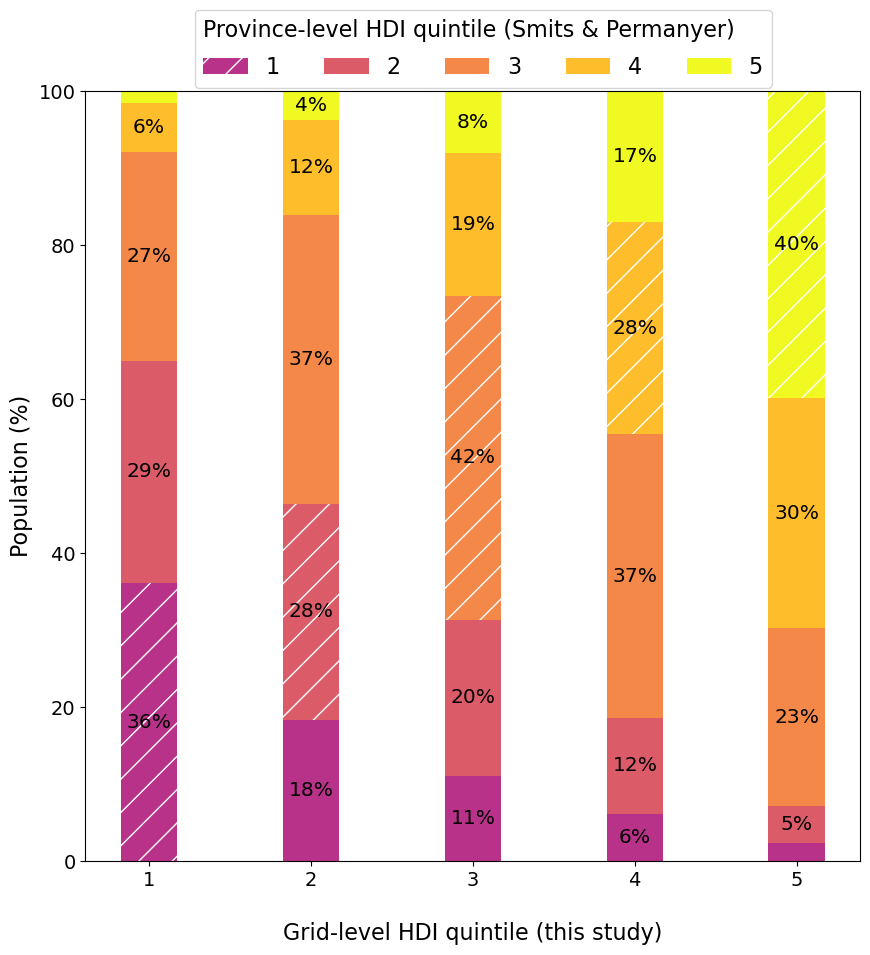

In [35]:
make_bar_plot(incs_and_bin_grid, pop_weight=True, alt_bin_text = "", true_bin_text = "", 
              savepath=repo_dir + "figures/Figure4B.pdf",
              x_lab_text = " \nGrid-level HDI quintile (this study)",
              #savepath=None
             )

In [36]:
### Bin change stats -- how many quintiles did people move?
incs_and_bin_grid["diff_bin"] = np.abs(incs_and_bin_grid["true_bin"] - incs_and_bin_grid["alt_bin"])

diffs = incs_and_bin_grid.groupby("diff_bin")["total_pop"].sum()
print("Percent of global pop by quintile change")
diffs/diffs.sum() * 100

Percent of global pop by quintile change


diff_bin
0.0    34.760236
1.0    41.471366
2.0    18.793830
3.0     4.203845
4.0     0.770724
Name: total_pop, dtype: float64

In [37]:
print("Percent of population that are put into a different quintile:",(1- (diffs/diffs.sum()).values[0] )* 100)


Percent of population that are put into a different quintile: 65.23976408656009


In [38]:
### Bin change stats -- how many quintiles did people move - with directionality?
incs_and_bin_grid["diff_bin2"] = incs_and_bin_grid["true_bin"] - incs_and_bin_grid["alt_bin"]

diffs = incs_and_bin_grid.groupby("diff_bin2")["total_pop"].sum()
print("Percent of global pop by quintile change")
diffs/diffs.sum() * 100

Percent of global pop by quintile change


diff_bin2
-4.0     0.305885
-3.0     2.031856
-2.0     9.494614
-1.0    20.422812
 0.0    34.760236
 1.0    21.048554
 2.0     9.299215
 3.0     2.171989
 4.0     0.464839
Name: total_pop, dtype: float64

In [39]:
dat = incs_and_bin_grid.groupby(["true_bin","alt_bin"])["total_pop"].sum()
perc_data = (dat / tot_array(dat)).reset_index()

In [40]:
### Get percent of bottom two quintiles that are now in top two
perc_data = perc_data.reset_index()

print("percent of bottom two that move from bottom two to top two:")
perc_data[ (perc_data["true_bin"] > 3) & (perc_data["alt_bin"] < 3)]["total_pop"].sum() /\
perc_data.loc[ (perc_data["true_bin"] < 3),"total_pop"].sum() * 100

percent of bottom two that move from bottom two to top two:


12.881626784760902

In [41]:
#make_confusion(dat, savepath=None,ystr="Grid")

In [47]:
# incs_and_bin.rename(columns={
#     "shapeID":"ADM2_shapeID",
#     "shapeGroup":"iso",
#     "adm1_truth":"adm1_hdi",
#     "true_bin":"adm2_bin",
#     "alt_bin": "adm1_bin",
    
#                            }).drop(columns = ["GDL_ADM1","percent_overlap_GDL_ADM1","shapeName","diff_bin"]).to_csv("adm2_preds_and_bins.csv")

In [46]:
# incs_and_bin_grid.rename(columns={
#     "shapeID":"ADM2_shapeID",
#     "shapeGroup":"iso",
#     "Sub-national HDI":"adm1_hdi",
#     "clipped": "adm2_grid_est_hdi",
#     "true_bin":"grid_bin",
#     "alt_bin": "adm1_bin",
    
#                            }).drop(columns = ["GDLCODE",
#                                               "centered_pred","diff_bin","diff_bin2",]).to_csv("grid_preds_and_bins.csv")